In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras import layers
import tensorflow_datasets as dfds

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
import ssl
import certifi
import urllib3
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())

In [4]:
splits = dfds.Split.ALL.subsplit(weighted=(80,20))
splits, info = dfds.load('cats_vs_dogs', with_info = True, as_supervised = True, split = splits)
(train_data, test_data)=splits

In [5]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [6]:
for i, example_image in enumerate(train_data.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


In [7]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
BATCH_SIZE = 16
IMAGE_RES = 224
m = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [8]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

train_batches      = train_data.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = test_data.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = m.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'tabby', 'papillon', 'toy terrier', 'tabby',
       'toy terrier', 'Egyptian cat', 'miniature poodle', 'tabby',
       'Pembroke', 'papillon', 'tiger cat', 'lynx', 'Shih-Tzu', 'tabby',
       'Persian cat'], dtype='<U30')

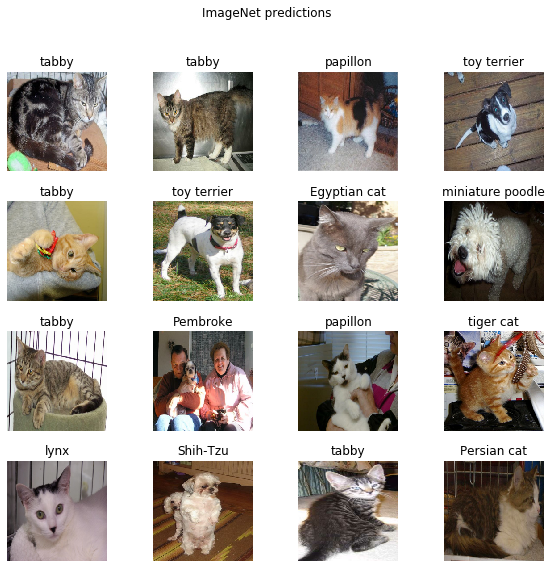

In [10]:
plt.figure(figsize=(10,9))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")